# Regression Modeling

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import calendar
import json
from datetime import datetime, timedelta
from tqdm import tqdm # progress bar
from time import time
from collections import Counter

import tensorflow as tf
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor

# Ignore warning, should be commented when implementing
import warnings
warnings.filterwarnings("ignore")

DATA_PATH = './data'

In [2]:
# Loading data
train = pd.read_csv(DATA_PATH + './train.csv')
specs = pd.read_csv(DATA_PATH + './specs.csv')
train_labels = pd.read_csv(DATA_PATH + './train_labels.csv')
test = pd.read_csv(DATA_PATH + './test.csv')
submission = pd.read_csv(DATA_PATH + './sample_submission.csv')

### Encode neccessary features

In [3]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
   
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, activities_map, assess_titles, list_of_event_id, all_title_event_code

In [4]:
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, activities_map, assess_titles,list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)

In [5]:
# Clip time dict used for encoding clip duration
clip_time = {'Welcome to Lost Lagoon!':19,
             'Tree Top City - Level 1':17,
             'Ordering Spheres':61, 
             'Costume Box':61,
             '12 Monkeys':109,
             'Tree Top City - Level 2':25, 
             'Pirate\'s Tale':80, 
             'Treasure Map':156,
             'Tree Top City - Level 3':26,
             'Rulers':126, 'Magma Peak - Level 1':20, 
             'Slop Problem':60, 'Magma Peak - Level 2':22, 
             'Crystal Caves - Level 1':18,
             'Balancing Act':72, 'Lifting Heavy Things':118,
             'Crystal Caves - Level 2':24, 'Honey Cake':142, 
             'Crystal Caves - Level 3':19,
             'Heavy, Heavier, Heaviest':61,
            }

A small notice:
> An `installation_id` in **test set** can have many Assessment session but the last Assessment has no attempts (4110 or 4100)

### Adding more features to the baseline:
- Convert `world` to numerical form
- Add corresponding `world` of assessment.
    - `assessment_world_code`
- Accumulated number of different previous assessments
    - `assessment_1`, `assessment_4`, `assessment_16`, `assessment_18`, `assessment_39`, 
- Add `duration_std` along with `duration_mean`
- Add `accumulated_assessment_attemps`
- Add combination of `session_title_code` of an assessment with corresponding `accuracy_group`
    - `assessment_accuracy_map`
- Add clip/activity/game duration mean and std

In [6]:
def get_assessment_code(activities_map):
    '''
    Get code of assessments in activities_map, 
    since it is randomly generated each time
    '''
    code_list = []
    for key in activities_map.keys():
        if 'assessment' in key.lower():
            code_list.append(str(activities_map[key]))
    return code_list

def get_assessment_accuracy_map():
    '''
    Create a dict mapping accuracy_group to each assessment code
    '''
    labels = ['0','1','2','3']
    assesment_code_list = get_assessment_code(activities_map)
    assessment_accuracy_map = {}
    for assess_code in assesment_code_list:
        for l in labels:
            assessment_accuracy_map[assess_code + '_' + l] = 0
    del assesment_code_list, labels
    return assessment_accuracy_map

def get_assessment_code_map():
    assesment_code_list = get_assessment_code(activities_map)
    assessment_code_map = {}
    for assess_code in assesment_code_list:
        assessment_code_map['assessment_' + assess_code] = 0
    del assesment_code_list
    return assessment_code_map

def get_data(user_sample, test_set=False):
    '''
    Take the data grouped by an installation_id and return the assessments with all calculated historic data
    '''
    assessment_accuracy_map = get_assessment_accuracy_map()
    assessment_code_map = get_assessment_code_map()
    
    user_activities_count = {'type_Clip':0, 'type_Activity': 0, 'type_Assessment': 0, 'type_Game':0, 
                             'world_0':0, 'world_1':0, 'world_2':0, 'world_3':0}
    user_activities_count.update(assessment_code_map)
    
    # New features updated from sourced kernel
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    total_accuracy_group = 0
    total_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_events = 0
    assessment_counter = 0
    
    # Duration features
    durations = []
    clip_durations = []
    activity_durations = []
    game_durations = []
    
    for i, session in user_sample.groupby('game_session', sort=False):
        session_type = session['type'].iloc[0]
        session_world = session['world'].iloc[0]
        session_title = session['title'].iloc[0]
        if test_set == True:
            second_condition = True
        else: # if this is a training set, make sure it has Assessment attemps
            if ((session['event_code'] == 4110) | (session['event_code'] == 4100)).any():
                second_condition = True
            else:
                second_condition= False
                         
        if session_type == 'Clip':
            clip_durations.append((clip_time[activities_labels[session_title]]))
        
        if session_type == 'Activity':
            activity_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
        
        if session_type == 'Game':
            game_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
                
        if (session_type == 'Assessment') & (second_condition):
            user_activities_count['assessment_'+ str(session_title)] += 1
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            
            features = user_activities_count.copy()
            
            # New features from the sourced kernel
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                
            features['installation_id'] = session['installation_id'].iloc[0]
            features['session_title_code'] = session['title'].iloc[0] 
            features['assessment_world_code'] = session_world
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1]['timestamp'] - session.iloc[0]['timestamp']).seconds)
            
            if clip_durations == []:
                features['Clip_duration_mean'] = 0
                features['Clip_duration_std'] = 0
            else:
                features['Clip_duration_mean'] = np.mean(clip_durations)
                features['Clip_duration_std'] = np.std(clip_durations)
                
            if activity_durations == []:
                features['Activity_duration_mean'] = 0
                features['Activity_duration_std'] = 0
            else:
                features['Activity_duration_mean'] = np.mean(activity_durations)
                features['Activity_duration_std'] = np.std(activity_durations)
                
            if game_durations == []:
                features['Game_duration_mean'] = 0
                features['Game_duration_std'] = 0
            else:
                features['Game_duration_mean'] = np.mean(game_durations)
                features['Game_duration_std'] = np.std(game_durations)
            
            features['accumulated_accuracy'] = total_accuracy/assessment_counter if assessment_counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            total_accuracy += accuracy
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
                
            features.update(accuracy_groups)
            features.update(assessment_accuracy_map)
            
            features['accumulated_assessment_attemps'] = sum(accuracy_groups.values())
            features['accumulated_accuracy_group'] = total_accuracy_group/assessment_counter if assessment_counter > 0 else 0
            features['accumulated_events'] = accumulated_events
            total_accuracy_group += features['accuracy_group']
            accuracy_groups[features['accuracy_group']] += 1
            assessment_accuracy_map[str(session['title'].iloc[0]) + '_' + str(features['accuracy_group'])] += 1
            
            all_assessments.append(features)
            assessment_counter += 1
            
        # this piece counts how many actions were made in each event_code so far
        def update_counters(counter: dict, col: str):
            num_of_session_count = Counter(session[col])
            for k in num_of_session_count.keys():
                x = k
                if col == 'title':
                    x = activities_labels[k]
                counter[x] += num_of_session_count[k]
            return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        
        
        accumulated_events += len(session)
        user_activities_count['type_'+session_type] += 1
        user_activities_count['world_'+str(session_world)] += 1

    if test_set:
        return all_assessments[-1]
    return all_assessments

In [7]:
compiled_train = []
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=17000):
    compiled_train += get_data(user_sample)

100%|████████████████████████████████████████████████████████████████████████████| 17000/17000 [07:23<00:00, 38.35it/s]


In [8]:
new_train = pd.DataFrame(compiled_train)
del compiled_train
new_train.shape

(17692, 937)

### Processing Test set

In [9]:
# Processing test set
compiled_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
    a = get_data(user_sample, test_set=True)
    compiled_test.append(a)
    
new_test = pd.DataFrame(compiled_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.87it/s]


## Feature Selection

- Eliminate high correlated features ? Doing this seems to lower the score of public test set.
- Scaling features:
    - Standardizing would lead to a very low score of test set. 
    - Furthermore, tree-based models (lightgbm, xgboost, catboost) are not distance based models and hence, can handle varying range of features.
- Eliminate low-variance features?
    - There seems to be no low-variance feature

In [10]:
# Preprocess feature names to avoid "Special JSON characters" error of LightGBM
new_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in new_train.columns]
new_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in new_test.columns]

In [11]:
# Call feature engineering functions
cat_features = ['session_title_code','assessment_world_code']
features = new_train.loc[(new_train.sum(axis=1) != 0), (new_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group','installation_id']]

In [12]:
# Selecting high-correlated features
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(new_train[feat_a], new_train[feat_b])[0][1]
            if c > 0.99:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: type_Clip FEAT_B: 27253bdc - Correlation: 1.0
2: FEAT_A: world_3 FEAT_B: Welcome_to_Lost_Lagoon_ - Correlation: 1.0
3: FEAT_A: world_3 FEAT_B: Welcome_to_Lost_Lagoon__2000 - Correlation: 1.0
4: FEAT_A: assessment_20 FEAT_B: 9d29771f - Correlation: 0.9902367941418727
5: FEAT_A: assessment_20 FEAT_B: c74f40cd - Correlation: 0.9902297744191059
6: FEAT_A: assessment_20 FEAT_B: Mushroom_Sorter__Assessment__3021 - Correlation: 0.9902367941418727
7: FEAT_A: assessment_20 FEAT_B: Mushroom_Sorter__Assessment__3121 - Correlation: 0.9902297744191059
8: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259852533822
9: FEAT_A: 2050 FEAT_B: 08fd73f3 - Correlation: 0.9966124346503646
10: FEAT_A: 2050 FEAT_B: f71c4741 - Correlation: 0.9904124425193319
11: FEAT_A: 2050 FEAT_B: 5a848010 - Correlation: 0.992355236510153
12: FEAT_A: 2050 FEAT_B: 37c53127 - Correlation: 1.0
13: FEAT_A: 2050 FEAT_B: 2b9272f4 - Correlation: 0.999983903256798
14: FEAT_A: 2050 FEAT_B: f7e47413 - Correlation: 0.99021884

116: FEAT_A: 736f9581 FEAT_B: 9b23e8ee - Correlation: 1.0
117: FEAT_A: 736f9581 FEAT_B: Egg_Dropper__Activity__2020 - Correlation: 1.0
118: FEAT_A: 736f9581 FEAT_B: Egg_Dropper__Activity__2000 - Correlation: 1.0
119: FEAT_A: 5f5b2617 FEAT_B: Bottle_Filler__Activity__4080 - Correlation: 0.9999999999999999
120: FEAT_A: 7d5c30a2 FEAT_B: Dino_Dive_2060 - Correlation: 1.0
121: FEAT_A: bc8f2793 FEAT_B: Pan_Balance_4035 - Correlation: 1.0
122: FEAT_A: 29bdd9ba FEAT_B: Dino_Dive_2000 - Correlation: 1.0
123: FEAT_A: 3bf1cf26 FEAT_B: 1af8be29 - Correlation: 0.9998900860839074
124: FEAT_A: 3bf1cf26 FEAT_B: Happy_Camel_3020 - Correlation: 0.9998900860839074
125: FEAT_A: 3bf1cf26 FEAT_B: Happy_Camel_3120 - Correlation: 0.9999999999999999
126: FEAT_A: 88d4a5be FEAT_B: 160654fd - Correlation: 0.9989297106527708
127: FEAT_A: 88d4a5be FEAT_B: Mushroom_Sorter__Assessment__3020 - Correlation: 0.9989297106527708
128: FEAT_A: 88d4a5be FEAT_B: Mushroom_Sorter__Assessment__3120 - Correlation: 1.0
129: FEAT_A

222: FEAT_A: 31973d56 FEAT_B: Cart_Balancer__Assessment__3120 - Correlation: 1.0
223: FEAT_A: db02c830 FEAT_B: 3bfd1a65 - Correlation: 0.9999982205419902
224: FEAT_A: db02c830 FEAT_B: Mushroom_Sorter__Assessment__2025 - Correlation: 0.9999999999999999
225: FEAT_A: db02c830 FEAT_B: Mushroom_Sorter__Assessment__2000 - Correlation: 0.9999982205419902
226: FEAT_A: 5e3ea25a FEAT_B: Crystals_Rule_4070 - Correlation: 1.0
227: FEAT_A: 4e5fc6f5 FEAT_B: Cart_Balancer__Assessment__4090 - Correlation: 1.0
228: FEAT_A: c6971acf FEAT_B: 51311d7a - Correlation: 0.9931667723288344
229: FEAT_A: c6971acf FEAT_B: Dino_Drink_2000 - Correlation: 0.9931667723288344
230: FEAT_A: c6971acf FEAT_B: Dino_Drink_2060 - Correlation: 1.0
231: FEAT_A: 1cc7cfca FEAT_B: All_Star_Sorting_4030 - Correlation: 1.0
232: FEAT_A: 3edf6747 FEAT_B: Cauldron_Filler__Assessment__4035 - Correlation: 1.0
233: FEAT_A: 6d90d394 FEAT_B: Scrub_A_Dub_2000 - Correlation: 1.0
234: FEAT_A: e694a35b FEAT_B: Fireworks__Activity__4020 - Corre

330: FEAT_A: 461eace6 FEAT_B: Egg_Dropper__Activity__4020 - Correlation: 1.0
331: FEAT_A: 532a2afb FEAT_B: Cauldron_Filler__Assessment__2020 - Correlation: 1.0
332: FEAT_A: d88ca108 FEAT_B: Air_Show_2070 - Correlation: 1.0
333: FEAT_A: 7ab78247 FEAT_B: b80e5e84 - Correlation: 0.9998336639671014
334: FEAT_A: 7ab78247 FEAT_B: Egg_Dropper__Activity__3010 - Correlation: 1.0
335: FEAT_A: 7ab78247 FEAT_B: Egg_Dropper__Activity__3110 - Correlation: 0.9998336639671014
336: FEAT_A: bfc77bd6 FEAT_B: Chest_Sorter__Assessment__4080 - Correlation: 1.0
337: FEAT_A: 8b757ab8 FEAT_B: 44cb4907 - Correlation: 0.9998350601727668
338: FEAT_A: 8b757ab8 FEAT_B: Crystals_Rule_3120 - Correlation: 1.0
339: FEAT_A: 8b757ab8 FEAT_B: Crystals_Rule_3020 - Correlation: 0.9998350601727668
340: FEAT_A: 5e812b27 FEAT_B: Sandcastle_Builder__Activity__4030 - Correlation: 1.0
341: FEAT_A: 9e4c8c7b FEAT_B: 363d3849 - Correlation: 0.9992131086125489
342: FEAT_A: 9e4c8c7b FEAT_B: All_Star_Sorting_3010 - Correlation: 0.99921

437: FEAT_A: 15ba1109 FEAT_B: Air_Show_2000 - Correlation: 1.0
438: FEAT_A: e7e44842 FEAT_B: Watering_Hole__Activity__4090 - Correlation: 1.0
439: FEAT_A: 46cd75b4 FEAT_B: Chicken_Balancer__Activity__4022 - Correlation: 1.0
440: FEAT_A: d122731b FEAT_B: Cart_Balancer__Assessment__4100 - Correlation: 1.0
441: FEAT_A: d2278a3b FEAT_B: Bottle_Filler__Activity__2000 - Correlation: 1.0
442: FEAT_A: c0415e5c FEAT_B: Dino_Dive_4020 - Correlation: 1.0
443: FEAT_A: 828e68f9 FEAT_B: 795e4a37 - Correlation: 0.993763490094275
444: FEAT_A: 828e68f9 FEAT_B: Cart_Balancer__Assessment__3110 - Correlation: 0.9999999999999998
445: FEAT_A: 828e68f9 FEAT_B: Cart_Balancer__Assessment__3010 - Correlation: 0.993763490094275
446: FEAT_A: d3268efa FEAT_B: 28520915 - Correlation: 0.9989055302553063
447: FEAT_A: d3268efa FEAT_B: b5053438 - Correlation: 0.9995763379622705
448: FEAT_A: d3268efa FEAT_B: Cauldron_Filler__Assessment__3121 - Correlation: 0.9995763379622705
449: FEAT_A: d3268efa FEAT_B: Cauldron_Filler

In [15]:
print('Total Number of Removals:', counter)
print('-'* 30)
# print('Removed Features:', to_remove)

Total Number of Removals: 533
------------------------------


In [16]:
features = [x for x in features if x not in to_remove]
print("Number of features after removal: ", len(features))

Number of features after removal:  390


## Regression Modelling

In [17]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast qwk eval function for lgb.
    """
    dist = Counter(new_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(new_train)
    new_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True


def qwk(act,pred,n=4,hist_range=(0,3)):
    """
    QWK for normal use 
    """
    if pred.dtype != act.dtype:
        pred = np.round(pred).astype('int')
    O = confusion_matrix(act,pred)
    O = np.divide(O,np.sum(O))
    
    W = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            W[i][j] = ((i-j)**2)/((n-1)**2)
            
    act_hist = np.histogram(act,bins=n,range=hist_range)[0]
    prd_hist = np.histogram(pred,bins=n,range=hist_range)[0]
    
    E = np.outer(act_hist,prd_hist)
    E = np.divide(E,np.sum(E))
    
    num = np.sum(np.multiply(W,O))
    den = np.sum(np.multiply(W,E))
    print('Done scoring!')
    return 1-np.divide(num,den)

qwk_scorer = make_scorer(qwk, greater_is_better=True) # second param is used to differentiate loss and score

In [18]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_group_cv() # could be either group/stratified k-fold
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_stratified_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_group_cv(self):
        groups = new_train['installation_id'] # group by installation_id
        cv = GroupKFold(n_splits=self.n_splits)
        return cv.split(self.train_df, self.train_df[self.target], groups)
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits     

            print('-'*30)
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
            print('-'*30)
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [19]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 500 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals,
                plot=False)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                  'task_type': "CPU",
                  'iterations': 5000,
                  'od_type': "Iter",
                  'depth': 10,
                  # 'learning_rate': 0.01,
                  'colsample_bylevel': 0.5, 
                  'early_stopping_rounds': 100,
                  'l2_leaf_reg': 18,
                  'random_seed': 42,
                  'use_best_model': True,
                }
        return params

In [20]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 500 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.02,
                    'feature_fraction': 0.9,
                    'max_depth': 16,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params

In [21]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.02,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

In [22]:
class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = enc.get_feature_names()
                features.extend(cat_cols)
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.822805	valid_1's rmse: 0.966229
Early stopping, best iteration is:
[520]	training's rmse: 0.818127	valid_1's rmse: 0.96546
------------------------------
Partial score of fold 0 is: 0.6194555665178476
------------------------------
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.818931	valid_1's rmse: 1.00219
Early stopping, best iteration is:
[401]	training's rmse: 0.844216	valid_1's rmse: 1.00184
------------------------------
Partial score of fold 1 is: 0.5912009905548221
------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[359]	training's rmse: 0.858472	valid_1's rmse: 0.979958
------------------------------
Partial score of fold 2 is: 0.5699527843863459
------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38

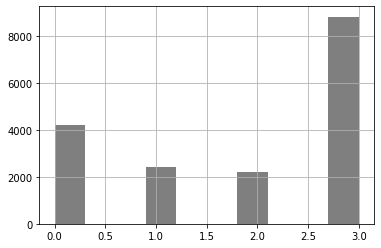

In [23]:
lgb_model = Lgb_Model(new_train, new_test, features, categoricals=cat_features)
xgb_model = Xgb_Model(new_train, new_test, features, categoricals=cat_features)
cat_model = Catb_Model(new_train, new_test, features, categoricals=cat_features)

(17692, 398)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               79800     
_________________________________________________________________
layer_normalization (LayerNo (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)    

13792/14153 [============================>.] - ETA: 0s - loss: 0.9627
Epoch 00025: val_loss did not improve from 0.94324
14153/14153 [==============================] - 1s 85us/sample - loss: 0.9626 - val_loss: 0.9561
Epoch 26/100
13728/14153 [============================>.] - ETA: 0s - loss: 0.9389
Epoch 00026: val_loss did not improve from 0.94324
14153/14153 [==============================] - 1s 85us/sample - loss: 0.9394 - val_loss: 0.9589
Epoch 27/100
13760/14153 [============================>.] - ETA: 0s - loss: 0.9403
Epoch 00027: val_loss did not improve from 0.94324
14153/14153 [==============================] - 1s 85us/sample - loss: 0.9412 - val_loss: 0.9608
Epoch 28/100
13824/14153 [============================>.] - ETA: 0s - loss: 0.9442
Epoch 00028: val_loss did not improve from 0.94324
14153/14153 [==============================] - 1s 93us/sample - loss: 0.9426 - val_loss: 0.9751
Epoch 29/100
13792/14153 [============================>.] - ETA: 0s - loss: 0.9354
Epoch 0002

Epoch 12/100
13632/14153 [===========================>..] - ETA: 0s - loss: 1.0663
Epoch 00012: val_loss did not improve from 1.09155
14153/14153 [==============================] - 1s 90us/sample - loss: 1.0649 - val_loss: 1.1176
Epoch 13/100
13760/14153 [============================>.] - ETA: 0s - loss: 1.0472
Epoch 00013: val_loss improved from 1.09155 to 1.06948, saving model to nn_model.w8
14153/14153 [==============================] - 1s 106us/sample - loss: 1.0432 - val_loss: 1.0695
Epoch 14/100
14112/14153 [============================>.] - ETA: 0s - loss: 1.0449
Epoch 00014: val_loss did not improve from 1.06948
14153/14153 [==============================] - 1s 100us/sample - loss: 1.0443 - val_loss: 1.0734
Epoch 15/100
14048/14153 [============================>.] - ETA: 0s - loss: 1.0244
Epoch 00015: val_loss did not improve from 1.06948
14153/14153 [==============================] - 2s 107us/sample - loss: 1.0250 - val_loss: 1.0834
Epoch 16/100
13824/14153 [==================

14144/14154 [============================>.] - ETA: 0s - loss: 2.0089
Epoch 00001: val_loss improved from inf to 1.10416, saving model to nn_model.w8
14154/14154 [==============================] - 2s 154us/sample - loss: 2.0090 - val_loss: 1.1042
Epoch 2/100
13632/14154 [===========================>..] - ETA: 0s - loss: 1.4488
Epoch 00002: val_loss improved from 1.10416 to 1.08458, saving model to nn_model.w8
14154/14154 [==============================] - 2s 119us/sample - loss: 1.4471 - val_loss: 1.0846
Epoch 3/100
14144/14154 [============================>.] - ETA: 0s - loss: 1.3257
Epoch 00003: val_loss improved from 1.08458 to 1.06838, saving model to nn_model.w8
14154/14154 [==============================] - 2s 112us/sample - loss: 1.3257 - val_loss: 1.0684
Epoch 4/100
13792/14154 [============================>.] - ETA: 0s - loss: 1.2603
Epoch 00004: val_loss improved from 1.06838 to 1.05207, saving model to nn_model.w8
14154/14154 [==============================] - 2s 112us/sampl

Epoch 00035: val_loss did not improve from 0.99756
14154/14154 [==============================] - 1s 104us/sample - loss: 0.8745 - val_loss: 1.0211
Epoch 36/100
14112/14154 [============================>.] - ETA: 0s - loss: 0.8698
Epoch 00036: val_loss did not improve from 0.99756
14154/14154 [==============================] - 1s 95us/sample - loss: 0.8699 - val_loss: 1.0373
Epoch 37/100
13664/14154 [===========================>..] - ETA: 0s - loss: 0.8543
Epoch 00037: val_loss did not improve from 0.99756
14154/14154 [==============================] - 1s 90us/sample - loss: 0.8588 - val_loss: 1.0555
Epoch 38/100
13920/14154 [============================>.] - ETA: 0s - loss: 0.8599
Epoch 00038: val_loss did not improve from 0.99756
14154/14154 [==============================] - 1s 89us/sample - loss: 0.8580 - val_loss: 1.0178
------------------------------
Partial score of fold 2 is: 0.5527325763915925
------------------------------
Model: "sequential_3"
_______________________________

Epoch 22/100
13792/14154 [============================>.] - ETA: 0s - loss: 0.9590
Epoch 00022: val_loss did not improve from 1.02576
14154/14154 [==============================] - 1s 85us/sample - loss: 0.9582 - val_loss: 1.0522
Epoch 23/100
13600/14154 [===========================>..] - ETA: 0s - loss: 0.9423
Epoch 00023: val_loss did not improve from 1.02576
14154/14154 [==============================] - 1s 90us/sample - loss: 0.9464 - val_loss: 1.0438
Epoch 24/100
14112/14154 [============================>.] - ETA: 0s - loss: 0.9465
Epoch 00024: val_loss did not improve from 1.02576
14154/14154 [==============================] - 1s 94us/sample - loss: 0.9459 - val_loss: 1.0558
Epoch 25/100
14144/14154 [============================>.] - ETA: 0s - loss: 0.9339
Epoch 00025: val_loss did not improve from 1.02576
14154/14154 [==============================] - 1s 100us/sample - loss: 0.9342 - val_loss: 1.0531
Epoch 26/100
13920/14154 [============================>.] - ETA: 0s - loss: 0.9

13696/14154 [============================>.] - ETA: 0s - loss: 1.1421
Epoch 00007: val_loss did not improve from 1.12371
14154/14154 [==============================] - 1s 87us/sample - loss: 1.1388 - val_loss: 1.1314
Epoch 8/100
13920/14154 [============================>.] - ETA: 0s - loss: 1.1286
Epoch 00008: val_loss improved from 1.12371 to 1.11520, saving model to nn_model.w8
14154/14154 [==============================] - 1s 98us/sample - loss: 1.1278 - val_loss: 1.1152
Epoch 9/100
13920/14154 [============================>.] - ETA: 0s - loss: 1.1075
Epoch 00009: val_loss improved from 1.11520 to 1.11500, saving model to nn_model.w8
14154/14154 [==============================] - 1s 98us/sample - loss: 1.1084 - val_loss: 1.1150
Epoch 10/100
13696/14154 [============================>.] - ETA: 0s - loss: 1.0958
Epoch 00010: val_loss did not improve from 1.11500
14154/14154 [==============================] - 1s 90us/sample - loss: 1.0973 - val_loss: 1.1189
Epoch 11/100
13856/14154 [===

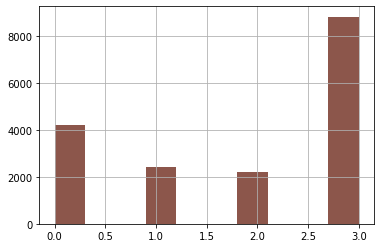

In [24]:
nn_model = Nn_Model(new_train, new_test, features, categoricals=cat_features)

## Ensemble Weighting

Ensemble predictions from the 4 models

In [25]:
weights = {'lbg': 0.25, 'cat': 0.25, 'xgb': 0.25, 'nn': 0.25}

preds = (lgb_model.y_pred * weights['lbg']) + cat_model.y_pred * weights['cat'] + (xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'])

The prediction of xgb and lgb are positively correlated. The ideal is they do not correlate significantly, so that ensemble model would extract different information from differnt inner models.

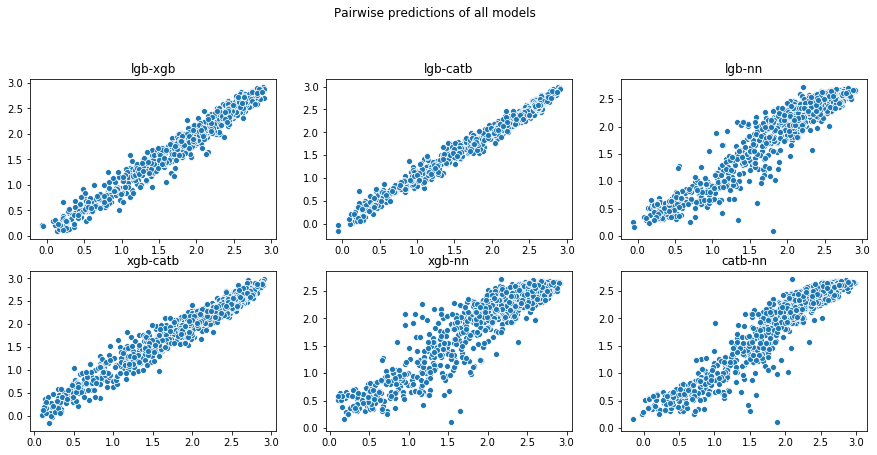

In [49]:
model_preds = {'lgb': lgb_model.y_pred, 
               'xgb': xgb_model.y_pred,
               'catb': cat_model.y_pred, 
               'nn': nn_model.y_pred}

plt.figure(figsize=(15,10))
plt_idx = 1
for i in range (0, len(model_preds)-1):
    i_key = list(model_preds.keys())[i]
    for j in range(i+1, len(model_preds)):
        j_key = list(model_preds.keys())[j]
        plt.subplot(3, 3, plt_idx)
        sns.scatterplot(model_preds[i_key], model_preds[j_key])
        plt.title(i_key + '-' + j_key)
        plt_idx += 1
plt.suptitle('Pairwise predictions of all models')
plt.show()

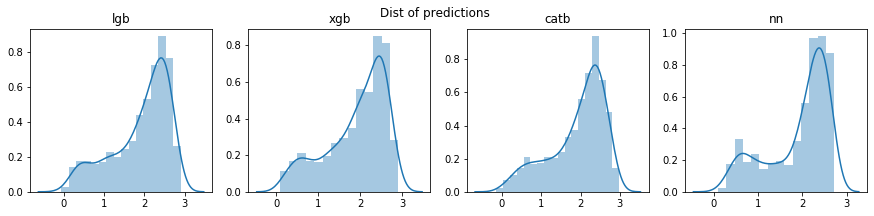

In [47]:
plt.figure(figsize=(15,3))

for idx, model in enumerate(model_preds):
    plt.subplot(1, len(model_preds), idx+1)
    sns.distplot(model_preds[model])
    plt.title(model)

plt.suptitle('Dist of predictions')
plt.show()

## Processing Submission

In [50]:
dist = Counter(new_train['accuracy_group'])
for k in dist:
    dist[k] /= len(new_train)

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(preds, acum * 100) # Returns the q-th percentile (which is acum*100 percentile) of the predictions


def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3

    
final_preds = np.array(list(map(classify, preds)))

In [51]:
submission['accuracy_group'] = final_preds.astype(int)
submission.to_csv('submission.csv', index=None)
submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [52]:
submission['accuracy_group'].value_counts()

3    500
0    239
1    137
2    124
Name: accuracy_group, dtype: int64

In [53]:
def get_solution_string(sub: pd.DataFrame) -> str:
    """
    Run this in your notebook with your test submission as input
    to get the output string and copy/paste into the cell below.
    
    e.g. get_solution_string(my_submission)
    """
    return (sub.installation_id + sub.accuracy_group.map(str)).str.cat()

In [ ]:
# get_solution_string(submission)

### Other things that not working
- https://www.kaggle.com/c/data-science-bowl-2019/discussion/124659
- https://www.kaggle.com/c/data-science-bowl-2019/discussion/125792

## References
This work is based on [this baseline solution](https://www.kaggle.com/braquino/convert-to-regression). Big kudos to the author for sharing this solution as we can learn so much from him.